### compute trends in SST CESM2-4p2z model runs for SSP3-7.0, SSP2-4.5, and SSP1-2.6

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
import cftime
import matplotlib.colors as colors
import utils

### First do SSP3-7.0

In [2]:
case = 'b.e21p4.BSSP370.f09_g17.4p2z.002'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + case + '/ocn/proc/tseries/month_1/'

In [3]:
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/b.e21p4.BSSP370.f09_g17.4p2z.002/ocn/proc/tseries/month_1/'

###  grab desired variables

In [4]:
variables = ['TEMP']

In [5]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    return ds

### define the data range

In [6]:
ds = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))  
    
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
    
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds = xr.merge([ds,ds_tmp],combine_attrs='override')

starting on  TEMP


In [7]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='05:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [8]:
cluster, client = get_ClusterClient()
cluster.scale(18) 
client

Client Scheduler: tcp://128.117.208.173:37757 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [10]:
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

### get coords

In [11]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA

In [12]:
ds_ann['time'] = np.arange(2015,2101,1)

In [13]:
da = ds_ann.TEMP

coeffs = da.polyfit('time', deg=1)

In [14]:
sst_trends_ssp370 = coeffs.polyfit_coefficients.isel(degree=0)

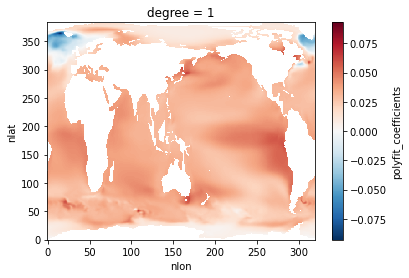

In [16]:
sst_trends_ssp370.plot()

### Make a map

Since this threshold was derived for an albatross species, it would make sense to mask continents in white and display only ocean (SST) values. The idea would be a simple two-color (or two-tone) map: for example, warm colors (red/orange) for extinction and cool colors (green/blue) for rescue.

- Areas where the temperature trend is greater than 0.0105 °C/year would correspond to population extinction.
- Areas where the trend is below this threshold would correspond to evolutionary rescue.

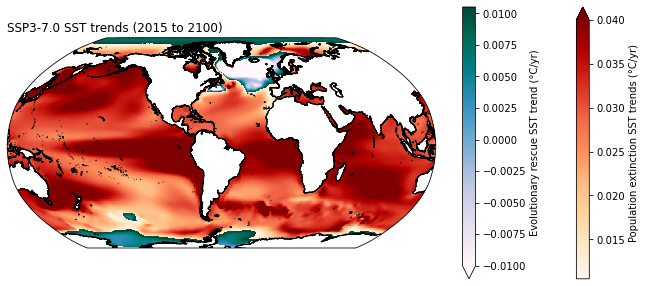

In [26]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('SSP3-7.0 SST trends (2015 to 2100)', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp370.where(sst_trends_ssp370>0.0105))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='OrRd',
                   vmin=0.0105,vmax=0.04)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='Population extinction SST trends (°C/yr)');

lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp370.where(sst_trends_ssp370<0.0105))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuBuGn',
                   vmin=-0.01,vmax=0.0105)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='min', label='Evolutionary rescue SST trend (°C/yr)');

### Get SSP 2-4.5

In [27]:
case = 'b.e21p4.BSSP245.f09_g17.4p2z.002'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + case + '/ocn/proc/tseries/month_1/'

In [28]:
ds = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))  
    
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
    
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds = xr.merge([ds,ds_tmp],combine_attrs='override')

starting on  TEMP


In [29]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [30]:
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

In [31]:
ds_ann['time'] = np.arange(2015,2101,1)

In [32]:
da = ds_ann.TEMP

coeffs = da.polyfit('time', deg=1)

In [33]:
sst_trends_ssp245 = coeffs.polyfit_coefficients.isel(degree=0)

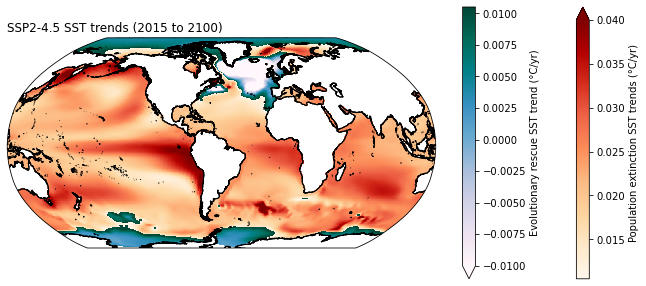

In [35]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('SSP2-4.5 SST trends (2015 to 2100)', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp245.where(sst_trends_ssp245>0.0105))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='OrRd',
                   vmin=0.0105,vmax=0.04)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='Population extinction SST trends (°C/yr)');

lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp245.where(sst_trends_ssp245<=0.0105))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuBuGn',
                   vmin=-0.01,vmax=0.0105)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='min', label='Evolutionary rescue SST trend (°C/yr)');

### Get SSP1-2.6

In [36]:
case = 'b.e21p4.BSSP126.f09_g17.4p2z.002'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + case + '/ocn/proc/tseries/month_1/'

In [37]:
ds = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))  
    
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
    
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds = xr.merge([ds,ds_tmp],combine_attrs='override')

starting on  TEMP


In [38]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [41]:
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

In [42]:
ds_ann['time'] = np.arange(2015,2101,1)

In [43]:
da = ds_ann.TEMP

coeffs = da.polyfit('time', deg=1)

In [44]:
sst_trends_ssp126 = coeffs.polyfit_coefficients.isel(degree=0)

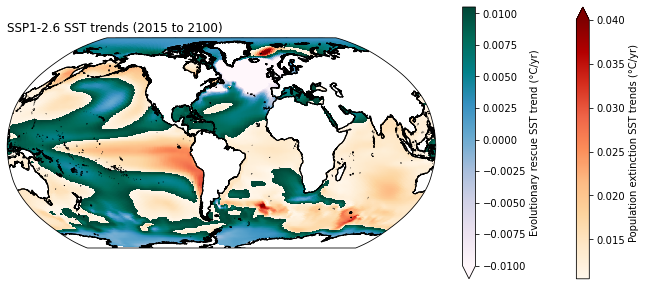

In [45]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('SSP1-2.6 SST trends (2015 to 2100)', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp126.where(sst_trends_ssp126>0.0105))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='OrRd',
                   vmin=0.0105,vmax=0.04)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='Population extinction SST trends (°C/yr)');

lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp126.where(sst_trends_ssp126<=0.0105))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuBuGn',
                   vmin=-0.01,vmax=0.0105)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='min', label='Evolutionary rescue SST trend (°C/yr)');

### Put all three maps together

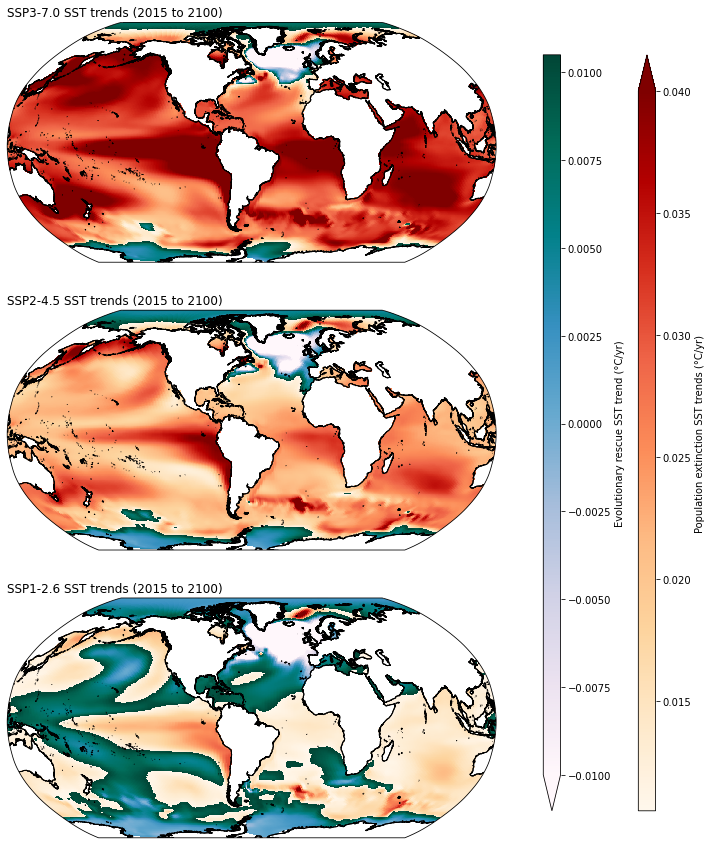

In [50]:
fig = plt.figure(figsize=(12,15))

############### 
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('SSP3-7.0 SST trends (2015 to 2100)', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp370.where(sst_trends_ssp370>0.0105))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='OrRd',
                   vmin=0.0105,vmax=0.04)


ax.coastlines('10m',linewidth=1)
#fig.colorbar(pc,extend='max', label='Population extinction SST trends (°C/yr)');

lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp370.where(sst_trends_ssp370<0.0105))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuBuGn',
                   vmin=-0.01,vmax=0.0105)


ax.coastlines('10m',linewidth=1)
#fig.colorbar(pc,extend='min', label='Evolutionary rescue SST trend (°C/yr)');


############### 
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('SSP2-4.5 SST trends (2015 to 2100)', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp245.where(sst_trends_ssp245>0.0105))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='OrRd',
                   vmin=0.0105,vmax=0.04)


ax.coastlines('10m',linewidth=1)
#fig.colorbar(pc,extend='max', label='Population extinction SST trends (°C/yr)');

lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp245.where(sst_trends_ssp245<=0.0105))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuBuGn',
                   vmin=-0.01,vmax=0.0105)


ax.coastlines('10m',linewidth=1)
#fig.colorbar(pc,extend='min', label='Evolutionary rescue SST trend (°C/yr)');


############### 
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('SSP1-2.6 SST trends (2015 to 2100)', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp126.where(sst_trends_ssp126>0.0105))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='OrRd',
                   vmin=0.0105,vmax=0.04)


ax.coastlines('10m',linewidth=1)
#fig.colorbar(pc,extend='max', label='Population extinction SST trends (°C/yr)');

lon,lat,field = utils.adjust_pop_grid(lons, lats, sst_trends_ssp126.where(sst_trends_ssp126<=0.0105))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuBuGn',
                   vmin=-0.01,vmax=0.0105)


ax.coastlines('10m',linewidth=1)
#fig.colorbar(pc,extend='min', label='Evolutionary rescue SST trend (°C/yr)');

#################
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.80, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='min',label='Evolutionary rescue SST trend (°C/yr)')

#################
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='max',label='Population extinction SST trends (°C/yr)')